## Wing sizing script

The aim of this script is to provide a basis for the prediction of stresses and deflections of the beam
This method will employ a simple FEM code to analyse a half wing under load.

First we perform some imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import src.deps.beamfe.beamfe as FEM
GSI = 9.81

The next cells deals with the mesh creation, the wing is discretised as a simple 3D slender beam

In [5]:
#Calculating node positions
def Nodes(xStart,xEnd,number):
    #Convert two 3-vectors, xStart, xend into a vector and mesh
    L = np.linalg.norm(xStart-xEnd) #Length of the beam
    n = (xEnd-xStart)/L
    return n, L, np.linspace(0,L,num=number)

In [6]:
#Building mesh
Nnodes =100
root = np.array([0,0,0])
tip = np.array([0,2002.0/2*1e-3,0])
direction, length, nodes = Nodes(root,tip,Nnodes)

Then we define the methods necessary to calculate the sectionnal properties of the beam.

The beam is modeled as a CF-foam-CF sandwich beam.

<img src="sandwichBeam.jpg" alt="drawing" width="200"/>

The equations for the moments of area, area and (linear)density are derived as:

$$(EI)_y = E_{cf}\left(\frac{bt^3}{6} + \frac{bt(c+t)^2}{2}\right) + E_{foam}\frac{bc^3}{12}$$

$$(EI)_z = E_{cf}\frac{tb^3}{6} + E_{foam}\frac{cb^3}{12}$$

$$A = (2t+c)b$$

Desity and EA are obtained by simple mixing rules

$c, t, b$ are all functions of $x$ and decision parameters

In [7]:
def EILayered(plate, core, b, t, c):
    #use formula to compyte the equivalent EI
    EIz = plate['E']*((b*t**3)/(6) + (b*t*(c+t)**2)/2) + core['E']*(b*c**3)/12
    EIy = plate['E']*((b**3*t)/6) + core['E']*(c*b**3)/12
    return EIy, EIz

def EALayered(plate, core, b, t, c):
    #compute the area of the plate
    return plate['E']*2*t*b + core['E']*c*b

def densityLayered(plate, core, b,t,c):
    return (2*t*plate['rho'] + c*core['rho'])/(c+2*t)

In [8]:
#problem properties
fibre = {'E' : 33e9, 'rho' : 1666.6,'sigTens': 400,'sigComp' : 200}
foam = {'E' : 1.9e9, 'rho' : 30.0,'sigTens': 22,'sigComp' : 22}

b = np.ones(Nnodes)*0.020
t = np.ones(Nnodes)*1e-3*2
chord = np.linspace(0.3,0.15,num=Nnodes)
c = np.linspace(0.03,0.015,num=Nnodes)

EIy, EIz = EILayered(fibre, foam, b,t,c)
EA = EALayered(fibre, foam, b,t,c)
density = densityLayered(fibre, foam, b,t,c)

We define two simple load cases:
    - Aerodynamic
    - Inertial (weight) 
The safety factor applied is $2.5\times1.2 = n\times1.2$

The aerodynamic load case is computed from a simple elliptic distribution:

$$ p_{aero}(x) = \frac{mgnf_{safety}}{\pi L^2}\sqrt{L^2-x^2}$$

In [9]:
#Load cases
safetyFactor = 1.2
maxLoadFactor = 2.5
weight_N = 6.9*GSI*safetyFactor*maxLoadFactor
LD_2D = 15
load = np.zeros((6,Nnodes))

lift = (weight_N*2)/(np.pi*length**2)*np.sqrt(length**2-nodes**2)
drag = lift/LD_2D
weight = -GSI*density*b*(2*t+c)*maxLoadFactor*safetyFactor
load[2,:] = lift + weight
load[1,:] = drag
assert(np.abs(np.trapz(lift,x=nodes)/(GSI*2.5*1.2)*2 - 6.9) < 0.05) #check that lift is below 50g off

Solving the problem with one clamped beam end, and on all Dof except rotation because calculating $(GJ)_x$ is difficult. 

In [10]:
#Step 4: Initialise the solver
def solve(load,nodes,density,EA,EIy,EIz):
    load = FEM.interleave(load.T)
    prob = FEM.BeamFE(nodes,density,EA,EIy,EIz)
    prob.set_boundary_conditions(left='C',right='F')
    prob.set_dofs([True,True,True,False,True,True])
    return prob.static_deflection(prob.distribute_load(load))[0]
x = solve(load,nodes,density,EA,EIy,EIz)

In [11]:
δ = FEM.deleave(x)
disp = {'x' :  δ[0,:],
        'y' :  δ[1,:],
        'z' :  δ[2,:],
        'rx' : δ[3,:],
        'ry' : δ[4,:],
        'rz' : δ[5,:]}

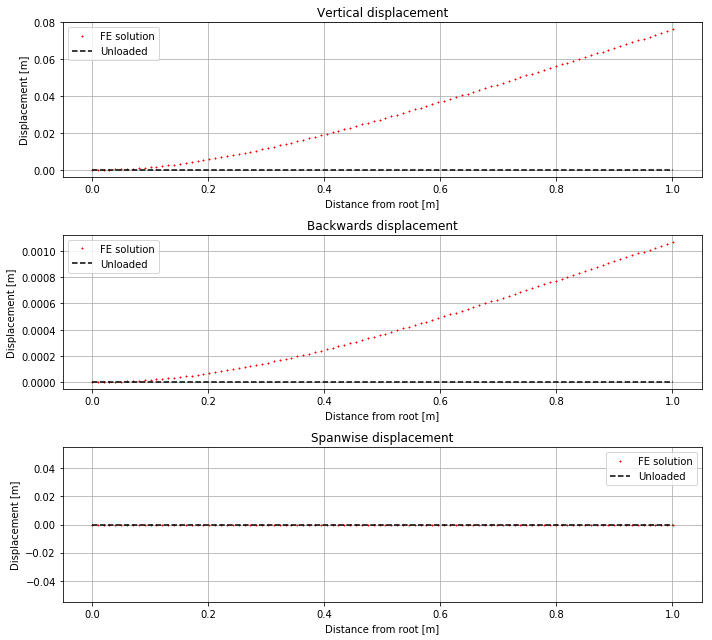

In [12]:
#Displacement
fig, axs = plt.subplots(nrows=3)
axs[0].plot(nodes,disp['z'],'+',c='red',ms=2,label='FE solution')
axs[0].plot(nodes,nodes*0,'--k',label='Unloaded')
axs[0].legend()
axs[0].set_xlabel('Distance from root [m]')
axs[0].set_ylabel('Displacement [m]')
axs[0].grid(True)
axs[0].set_title("Vertical displacement")

axs[1].plot(nodes,disp['y'],'+',c='red',ms=1.6,label='FE solution')
axs[1].plot(nodes,nodes*0,'--k',label='Unloaded')
axs[1].legend()
axs[1].set_xlabel('Distance from root [m]')
axs[1].set_ylabel('Displacement [m]')
axs[1].grid(True)
axs[1].set_title("Backwards displacement")


axs[2].plot(nodes,disp['x'],'+',c='red',ms=1.6,label='FE solution')
axs[2].plot(nodes,nodes[::-1]*0,'--k',label='Unloaded')
axs[2].legend()
axs[2].set_xlabel('Distance from root [m]')
axs[2].set_ylabel('Displacement [m]')
axs[2].grid(True)
axs[2].set_title("Spanwise displacement")


fig.set_size_inches((10,9))
fig.tight_layout()


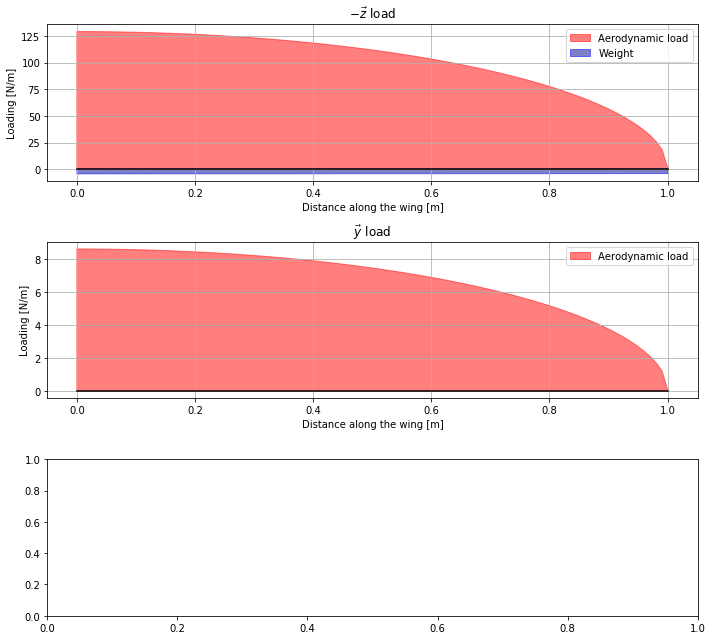

In [13]:
#Load visualisation
fig, axs = plt.subplots(nrows=3)
axs[0].plot(nodes,nodes*0,'k')
axs[0].fill_between(nodes,0,lift,label='Aerodynamic load',hatch='',edgecolor='red',alpha=0.5,facecolor='red')
axs[0].fill_between(nodes,0,weight,label='Weight',hatch='',edgecolor='blue',alpha=0.5,facecolor='darkblue')
axs[0].legend()
axs[0].set_xlabel('Distance along the wing [m]')
axs[0].set_ylabel('Loading [N/m]')
axs[0].set_title(r'$-\vecz$ load')
axs[0].grid(True)

axs[1].plot(nodes,nodes*0,'k')
axs[1].fill_between(nodes,0,drag,label='Aerodynamic load',hatch='',edgecolor='red',alpha=0.5,facecolor='red')
axs[1].legend()
axs[1].set_xlabel('Distance along the wing [m]')
axs[1].set_ylabel('Loading [N/m]')
axs[1].set_title(r'$\vecy$ load')
axs[1].grid(True)
fig.set_size_inches((10,9))
fig.tight_layout()

## Checking failure
We check failure through simple beam stress computations.

$$ \sigma_{\max,x} = \max_{y,z} - yE\frac{d^2w_y}{{dx}^2} -zE\frac{d^2w_z}{{dx}^2}$$

We can allow some simplifications (ie rectangular sections)

True

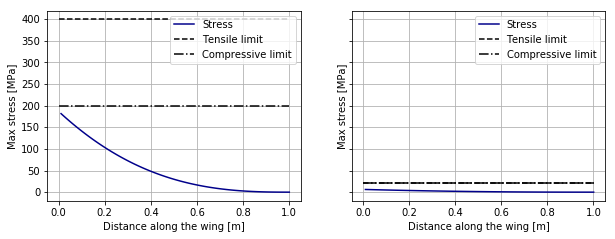

In [14]:
#Step 5: Report on the design
#Computing the stresses in the design

def stressArray(rot,E,y,dx):
    #differentiate the rotation array
    d2w = np.diff(rot)/dx
    #compute the stress and return
    return -E*y[1:]*d2w

def strainArray(rot,E,y,dx):
    d2w = np.diff(rot)/dx
    return -y[1:]*d2w

def stressPlot(fig,ax,disp,fibre,foam,c,b,t,nodes):
    #fibre: 
    fiby = np.abs(stressArray(disp['ry'],fibre['E'],c/2+t,nodes[1]-nodes[0]))
    fomy = np.abs(stressArray(disp['ry'],foam['E'],b/2,nodes[1]-nodes[0]))
    
    fibz = np.abs(stressArray(disp['rz'],fibre['E'],c/2+t,nodes[1]-nodes[0]))
    fomz = np.abs(stressArray(disp['rz'],foam['E'],b/2,nodes[1]-nodes[0]))
    
    #max tensile:
    fibTens = fiby + fibz
    fomTens = fomy + fomz
    
    fibAx = ax[0]
    fomAx = ax[1]
    
    fibAx.plot(nodes[1:],fibTens*1e-6,c="darkblue",label="Stress")
    fomAx.plot(nodes[1:],fomTens*1e-6,c="darkblue",label="Stress")
    
    fibAx.hlines(fibre['sigTens'],nodes[0],nodes[-1],linestyles= 'dashed',label="Tensile limit")
    fibAx.hlines(fibre['sigComp'],nodes[0],nodes[-1],linestyles= 'dashdot',label="Compressive limit")
    
    fomAx.hlines(foam['sigTens'],nodes[0],nodes[-1],linestyles= 'dashed',label="Tensile limit")
    fomAx.hlines(foam['sigComp'],nodes[0],nodes[-1],linestyles= 'dashdot',label="Compressive limit")
    for AX in (fibAx, fomAx):
        AX.grid(True)
        AX.set_xlabel("Distance along the wing [m]")
        AX.set_ylabel("Max stress [MPa]")
        AX.legend()
    
    
    if np.any(fibTens*1e-6 > min(fibre['sigTens'],fibre['sigComp'])):
        return False, "Fibres fails"
    elif np.any(fomTens*1e-6 > min(foam['sigTens'],foam['sigComp'])):
        return False, "Foam fails"
    else:
        return True
#stresses due to bending in Y

fig,ax = plt.subplots(ncols = 2,sharey=True)
fig.set_size_inches((10,3.5))
stressPlot(fig,ax,disp,fibre,foam,c,b,t,nodes)

In [15]:
def polygon_area(x,y):
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)

In [19]:
#mass evaluation
area = 1.47
#calculate the wetted area
af = np.genfromtxt('./in/6043.dat')
specSurf = np.sum([np.sqrt((af[i+1,0]-af[i,0])**2+(af[i+1,1]-af[i,1])**2) for i in range(len(af)-1)])
Swet = 2*np.trapz(specSurf*chord,x=nodes)
specSection = polygon_area(af[:,0],af[:,1])
volume = 2*np.trapz(specSection*chord**2,x=nodes)
mass = 0 + Swet *0.08
print("Estimated mass of the film: {:3.3f} [kg]".format(mass*2))
massinc = 2*np.trapz(foam['rho']*b*c + fibre['rho']*b*t*2,x=nodes)
mass += massinc
print("Estimated mass of the beam: {:3.3f} [kg]".format(massinc*2))
massinc = volume*.5*foam['rho']
mass += massinc
print("Estimated mass of the ribs: {:3.3f} [kg]".format(massinc*2))
print("Estimated mass: {:3.3f} [kg]".format(mass*2))
print("=======================================".format(mass))
print("Total mass: {:3.3f} [kg]".format(mass*2))

Estimated mass of the film: 0.148 [kg]
Estimated mass of the beam: 0.588 [kg]
Estimated mass of the ribs: 0.216 [kg]
Estimated mass: 0.952 [kg]
Total mass: 0.952 [kg]
